# 06: Onshore multifidelity

In this example, we will demonstrate `Ard`'s ability to run a layout-to-LCOE analysis and optimization.

We can start by loading what we need to run the problem.

In [1]:
from pathlib import Path  # optional, for nice path specifications

import pprint as pp  # optional, for nice printing
import numpy as np  # numerics library
import matplotlib.pyplot as plt  # plotting capabilities

import ard  # technically we only really need this
from ard.utils.io import load_yaml  # we grab a yaml loader here
from ard.api import set_up_ard_model  # the secret sauce
from ard.viz.layout import plot_layout  # a plotting tool!
from ard.viz.utils import get_plot_range  # buffered range tool

import openmdao.api as om  # for N2 diagrams from the OpenMDAO backend

%matplotlib inline

This will do for now.
We can probably make it a bit cleaner for a later release.

Now, we can set up a case.
We do it a little verbosely so that our documentation system can grab it, you can generally just use relative paths.
We grab the file at `inputs/ard_system.yaml`, which describes the `Ard` system for this problem.
It references, in turn, the `inputs/windio.yaml` file, which is where we define the plant we want to optimize, and an initial setup for it.

In [2]:
# load input
path_inputs = Path.cwd().absolute() / "inputs"
input_dict = load_yaml(path_inputs / "ard_system.yaml")

# create and setup system
prob = set_up_ard_model(input_dict=input_dict, root_data_path=path_inputs)

Adding top_level
Adding layout2aep
Adding layout to layout2aep
Adding aepFLORIS to layout2aep
	Activating approximate totals on layout2aep
Adding boundary
Adding landuse
Adding collection
Adding spacing_constraint
Adding tcc
Adding landbosse
Adding opex
Adding financese


Here, you should see each of the groups or components described as they are added to the `Ard` model and, occasionally, some options being turned on on them, like semi-total finite differencing on groups.

Next is some code you can flip on to use the [N2 diagram vizualization tools from the backend toolset, OpenMDAO, that we use](https://openmdao.org/newdocs/versions/latest/features/model_visualization/n2_basics/n2_basics.html).
This can be a really handy debugging tool, if somewhat tricky to use; turned on it will show a comprehensive view of the system in terms of its components, variables, and connections, although we leave it off for now.

In [3]:
if False:
    # visualize model
    om.n2(prob)

Now, we do a one-shot analysis.
The one-shot analysis will run a wind farm as specified in `inputs/windio.yaml` and with the models specified in `inputs/ard_system.yaml`, then dump the outputs.

In [4]:
# run the model
prob.run_model()

# collapse the test result data
test_data = {
    "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
    "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
    "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
    "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
    "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
    "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
    "coll_length": float(prob.get_val("collection.total_length_cables", units="km")[0]),
    "turbine_spacing": float(
        np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
    ),
}

print("\n\nRESULTS:\n")
pp.pprint(test_data)
print("\n\n")



RESULTS:

{'AEP_val': 406.5372933434125,
 'BOS_val': 41.68227106807093,
 'CapEx_val': 110.5,
 'LCOE_val': 37.274982094458494,
 'OpEx_val': 3.7400000000000007,
 'area_tight': 13.2496,
 'coll_length': 21.89865877023397,
 'turbine_spacing': 0.91}





Now, we can optimize the same problem!
The optimization details are set under the `analysis_options` header in `inputs/ard_system.yaml`.
Here, we use a four-dimensional rectilinear layout parameterization ($\theta$) as design variables, constrain the farm such that the turbines are in the boundaries and satisfactorily spaced, and then we optimize for LCOE.
$$
\begin{aligned}
\textrm{minimize}_\theta \quad & \mathrm{LCOE}(\theta, \ldots) \\
\textrm{subject to} \quad & f_{\mathrm{spacing}}(\theta, \ldots) < 0 \\
                          & f_{\mathrm{boundary}}(\theta, \ldots) < 0
\end{aligned}
$$

In [5]:
optimize = True  # set to False to skip optimization
if optimize:
    # run the optimization
    prob.run_driver()

    # collapse the test result data
    test_data = {
        "AEP_val": float(prob.get_val("AEP_farm", units="GW*h")[0]),
        "CapEx_val": float(prob.get_val("tcc.tcc", units="MUSD")[0]),
        "BOS_val": float(prob.get_val("landbosse.total_capex", units="MUSD")[0]),
        "OpEx_val": float(prob.get_val("opex.opex", units="MUSD/yr")[0]),
        "LCOE_val": float(prob.get_val("financese.lcoe", units="USD/MW/h")[0]),
        "area_tight": float(prob.get_val("landuse.area_tight", units="km**2")[0]),
        "coll_length": float(
            prob.get_val("collection.total_length_cables", units="km")[0]
        ),
        "turbine_spacing": float(
            np.min(prob.get_val("spacing_constraint.turbine_spacing", units="km"))
        ),
    }

    # clean up the recorder
    prob.cleanup()

    # print the results
    print("\n\nRESULTS (opt):\n")
    pp.pprint(test_data)
    print("\n\n")

generation: 0 of 30
generation: 1 of 30
generation: 2 of 30
generation: 3 of 30
generation: 4 of 30
generation: 5 of 30
generation: 6 of 30
generation: 7 of 30
generation: 8 of 30
generation: 9 of 30
generation: 10 of 30
generation: 11 of 30
generation: 12 of 30
generation: 13 of 30
generation: 14 of 30
generation: 15 of 30
generation: 16 of 30
generation: 17 of 30
generation: 18 of 30
generation: 19 of 30
generation: 20 of 30
generation: 21 of 30
generation: 22 of 30
generation: 23 of 30
generation: 24 of 30
generation: 25 of 30
generation: 26 of 30
generation: 27 of 30
generation: 28 of 30
generation: 29 of 30
generation: 30 of 30


RESULTS (opt):

{'AEP_val': 438.62482290015714,
 'BOS_val': 39.95436562994368,
 'CapEx_val': 110.5,
 'LCOE_val': 34.25268392907545,
 'OpEx_val': 3.7400000000000007,
 'area_tight': 4.770734196024792,
 'coll_length': 13.64484515168428,
 'turbine_spacing': 0.5586294914588025}





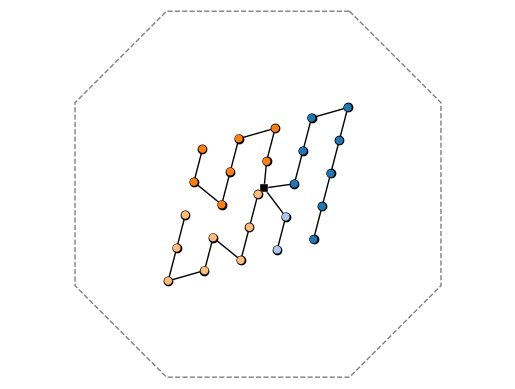

In [6]:
plot_layout(
    prob,
    input_dict=input_dict,
    show_image=True,
    include_cable_routing=True,
)
plt.show()

The result: a farm that fits in a stop-sign domain and minimzes the LCOE.

In [7]:
obj_nd = prob.driver.obj_nd.copy()
obj_nd = obj_nd[obj_nd[:, 0].argsort()]  # Sort rows by the first column

In [45]:
# plt.plot(
#     # *(obj_nd.T),
#     # *[
#     #     objective_driverscale*input_info["scaler"]*scaler_manual
#     #     for objective_driverscale, input_info, scaler_manual
#     #     in zip(
#     #         obj_nd.T,
#     #         np.flip(input_dict["analysis_options"]["objectives"].values()),
#     #         [1.0, 1.0],
#     #     )
#     # ],
#     obj_nd[:, 0],
#     obj_nd[:, 1],
# )

In [46]:
# Access the recorder data
case_reader = om.CaseReader(prob.get_outputs_dir() / "cases.sql")

# Get all driver cases
driver_cases = case_reader.list_cases("driver", out_stream=None)

# Extract data from all cases
results = []
for case_id in driver_cases:

    case = case_reader.get_case(case_id)

    # Extract specific variables you're interested in
    result = {
        "case_id": case_id,
        "LCOE": case.get_val("financese.lcoe", units="USD/MW/h")[0],
        'area_tight': case.get_val('area_tight', units='km*km')[0],
        # "AEP": case.get_val("AEP_farm", units="GW*h")[0],
        # 'CapEx': case.get_val('tcc.tcc', units='MUSD')[0],
        # 'OpEx': case.get_val('opex.opex', units='MUSD/yr')[0],
        # Add any design variables you want to track
        # 'design_vars': case.get_design_vars(),
        # 'constraints': case.get_constraints(),
    }
    results.append(result)

# Convert to arrays for plotting/analysis
case_id_history = np.array([int(r["case_id"].split('|')[-1]) for r in results])
lcoe_history = np.array([r["LCOE"] for r in results])
# aep_history = np.array([r["AEP"] for r in results])
area_tight_history = np.array([r['area_tight'] for r in results])

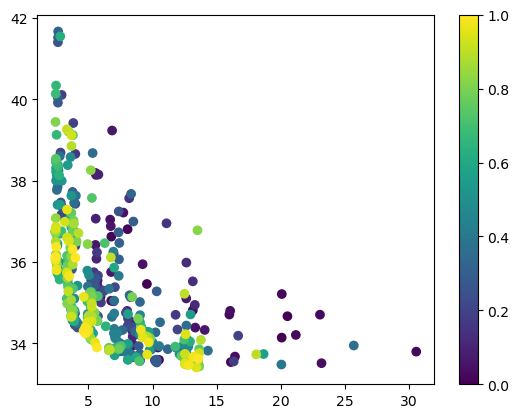

In [47]:
# plt.scatter(aep_history, lcoe_history, c=case_id_history/max(case_id_history))
# plt.colorbar()
# plt.scatter(area_tight_history, aep_history, c=case_id_history/max(case_id_history))
# plt.colorbar()
plt.scatter(area_tight_history, lcoe_history, c=case_id_history/max(case_id_history))
plt.colorbar()

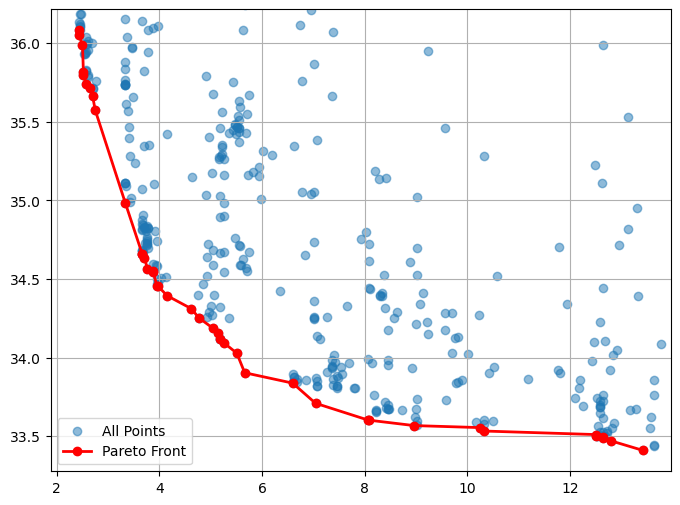

In [48]:
# Combine AEP and LCOE into a single array for easier processing
# data = np.column_stack((area_tight_history, aep_history))
# data = np.column_stack((aep_history, lcoe_history))
data = np.column_stack((area_tight_history, lcoe_history))

# Sort by AEP (descending) and then by LCOE (ascending)
# data = data[np.lexsort((area_tight_history, -aep_history))]
# data = data[np.lexsort((lcoe_history, -aep_history))]
data = data[np.lexsort((lcoe_history, area_tight_history))]

# Compute the Pareto front
pareto_front = [data[0]]
for point in data[1:]:
    if point[1] < pareto_front[-1][1]:  # Check if LCOE is lower
        pareto_front.append(point)

pareto_front = np.array(pareto_front)

# Extract AEP and LCOE values for the Pareto front
pareto0 = pareto_front[:, 0]
pareto1 = pareto_front[:, 1]

# Plot the Pareto front
plt.figure(figsize=(8, 6))
# plt.scatter(area_tight_history, aep_history, label="All Points", alpha=0.5)
# plt.scatter(aep_history, lcoe_history, label="All Points", alpha=0.5)
plt.scatter(area_tight_history, lcoe_history, label="All Points", alpha=0.5)
plt.plot(pareto0, pareto1, "-o", color="red", label="Pareto Front", linewidth=2)
# plt.xlabel("AEP (GW*h)")
# plt.ylabel("LCOE (USD/MW/h)")
# plt.title("Pareto Front: AEP Maximized and LCOE Minimized")
plt.legend()
plt.grid(True)
plt.xlim(*get_plot_range(pareto0))
plt.ylim(*get_plot_range(pareto1))
plt.show()